In [10]:
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp
import pickle
import pysindy as ps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import os
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from torch.fft import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
import optuna
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskLassoCV, LinearRegression
from sklearn.feature_selection import SelectFromModel
from typing import Tuple, Any, Iterable, Dict
from sklearn.model_selection import train_test_split


In [12]:
# Define the double pendulum dynamics
def double_pendulum(t, y, l1, l2, m1, m2, g):
    theta1, z1, theta2, z2 = y
    delta = theta2 - theta1

    # Equations of motion
    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta) ** 2
    denom2 = (l2 / l1) * denom1

    dydt = np.zeros_like(y)
    dydt[0] = z1
    dydt[1] = (
        (m2 * l1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
        + m2 * g * np.sin(theta2) * np.cos(delta)
        + m2 * l2 * z2 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta1))
        / denom1
    )
    dydt[2] = z2
    dydt[3] = (
        (-m2 * l2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
        + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
        - (m1 + m2) * l1 * z1 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta2))
        / denom2
    )
    return dydt

In [13]:
# Define the datasets size
n_pendulums = 1000
data = []

In [14]:
for _ in range(n_pendulums):
    # Randomize parameters
    l1, l2 = np.random.uniform(0.5, 2.0, 2)
    m1, m2 = np.random.uniform(0.5, 2.0, 2)
    g = 9.81
    y0 = np.random.uniform(-np.pi, np.pi, 4)

    # Simulate dynamics
    t_span = (0, 10)
    t_eval = np.linspace(t_span[0], t_span[1], 100)
    sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, args=(l1, l2, m1, m2, g))
    
    # Store data
    theta1, theta1_dot, theta2, theta2_dot = sol.y
    X = np.vstack([theta1, theta2, theta1_dot, theta2_dot]).T
    data.append((X, l1, l2, m1, m2, g))

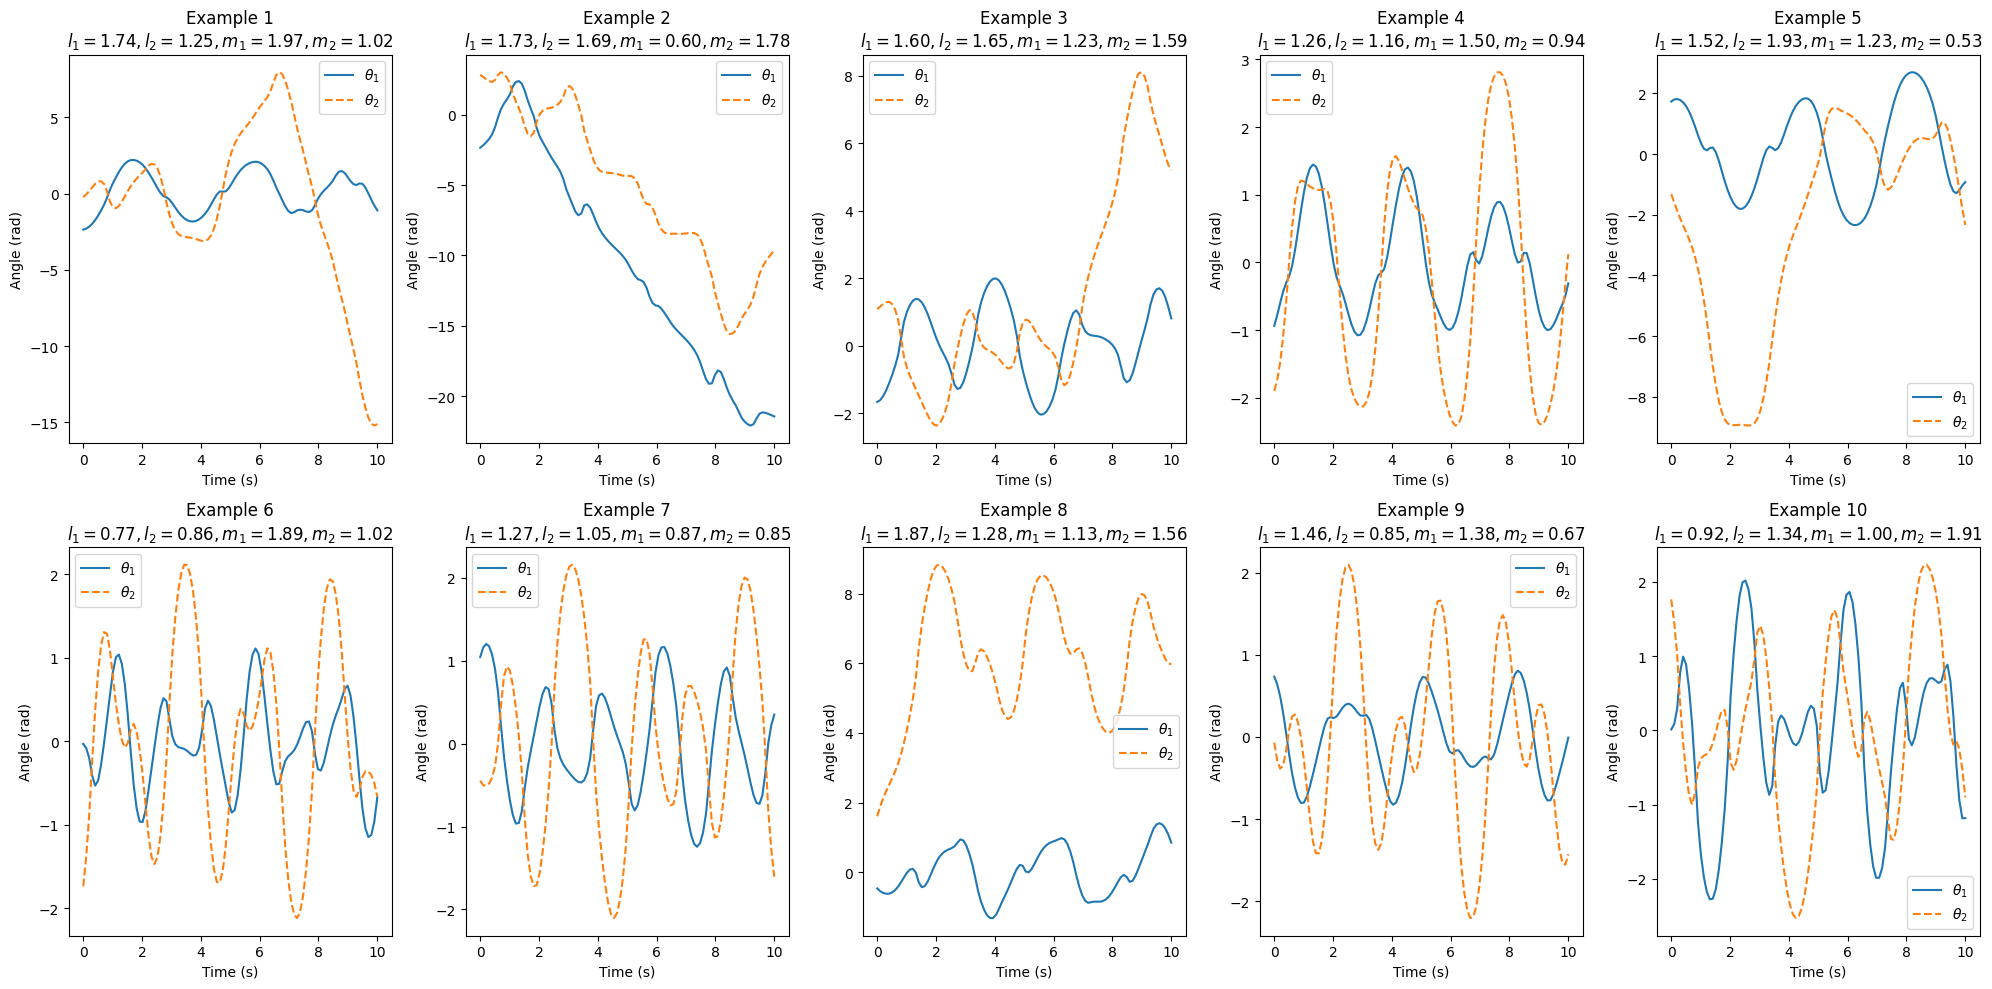

In [15]:
# Visualization of the double pendulum dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for i in range(10):
    # Extract example data
    X, l1, l2, m1, m2, g = data[i]
    theta1, theta2, theta1_dot, theta2_dot = X.T

    # Time points for visualization
    t = np.linspace(0, 10, 100)

    # Plot trajectory of theta1 and theta2
    ax = axes[i]
    ax.plot(t, theta1, label="$\\theta_1$")
    ax.plot(t, theta2, label="$\\theta_2$", linestyle="--")
    ax.set_title(f"Example {i+1}\n$l_1={l1:.2f}, l_2={l2:.2f}, m_1={m1:.2f}, m_2={m2:.2f}$")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (rad)")
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
# Split dataset into train, validation, and test sets
train_data = data[:800]
val_data = data[800:900]
test_data = data[900:]

In [17]:
# Save data as pickle
with open('double_pendulum_split_dataset.pkl', 'wb') as f:
    pickle.dump({'train': train_data, 'val': val_data, 'test': test_data}, f)

print(f"Dataset saved: Train={len(train_data)}, Validation={len(val_data)}, Test={len(test_data)} examples.")

Dataset saved: Train=800, Validation=100, Test=100 examples.


In [7]:
# Define PINN structure
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(units, activation='tanh') for units in layers]
        self.output_layer = tf.keras.layers.Dense(2)  # Outputs: [theta1_ddot, theta2_ddot]

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [8]:
# Physics-informed loss
def physics_loss(y_pred, y_true, params_batch):
    l1, l2, m1, m2, g = params_batch
    theta1, theta2, theta1_dot, theta2_dot = tf.split(y_true, 4, axis=1)
    theta1_ddot, theta2_ddot = tf.split(y_pred, 2, axis=1)

    delta = theta2 - theta1
    physics_term1 = (
        (m2 * l1 * theta1_dot ** 2 * tf.sin(delta) * tf.cos(delta)
         + m2 * g * tf.sin(theta2) * tf.cos(delta)
         + m2 * l2 * theta2_dot ** 2 * tf.sin(delta)
         - (m1 + m2) * g * tf.sin(theta1))
        / ((m1 + m2) * l1 - m2 * l1 * tf.cos(delta) ** 2)
    )
    physics_term2 = (
        (-m2 * l2 * theta2_dot ** 2 * tf.sin(delta) * tf.cos(delta)
         + (m1 + m2) * g * tf.sin(theta1) * tf.cos(delta)
         - (m1 + m2) * l1 * theta1_dot ** 2 * tf.sin(delta)
         - (m1 + m2) * g * tf.sin(theta2))
        / ((l2 / l1) * ((m1 + m2) * l1 - m2 * l1 * tf.cos(delta) ** 2))
    )

    loss = (
        tf.reduce_mean((theta1_ddot - physics_term1) ** 2)
        + tf.reduce_mean((theta2_ddot - physics_term2) ** 2)
    )
    return loss

In [9]:
def compute_accuracy(y_pred, y_true):
    # Extract accelerations from y_true
    theta1_ddot_true, theta2_ddot_true = tf.split(y_true[:, 2:], 2, axis=1)
    y_true_acc = tf.concat([theta1_ddot_true, theta2_ddot_true], axis=1)
    
    # Compute accuracy using only the accelerations
    return tf.reduce_mean(tf.abs(y_pred - y_true_acc) / (tf.abs(y_true_acc) + 1e-6))

In [11]:
# Load dataset
with open('double_pendulum_split_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [12]:
# Prepare training, validation, and test data
def prepare_data(data):
    X = np.vstack([example[0] for example in data]).astype(np.float32)
    y = X  # All state variables as targets
    params = np.array([example[1:] for example in data], dtype=np.float32).T
    return X, y, params

In [13]:
X_train, y_train, params_train = prepare_data(dataset['train'])
X_val, y_val, params_val = prepare_data(dataset['val'])
X_test, y_test, params_test = prepare_data(dataset['test'])

In [14]:
# Define and train the PINN
pinn = PINN([64, 64, 64])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [15]:
# Training loop
epochs = 50
batch_size = 32
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training
    for i in range(0, len(X_train), batch_size):
        X_batch = tf.constant(X_train[i:i + batch_size], dtype=tf.float32)  # Convert to tf.float32
        y_batch = tf.constant(y_train[i:i + batch_size], dtype=tf.float32)  # Convert to tf.float32
        params_batch = [tf.constant(param[i:i + batch_size], dtype=tf.float32) for param in params_train]

        with tf.GradientTape() as tape:
            y_pred = pinn(X_batch)
            loss = physics_loss(y_pred, y_batch, params_batch)

        gradients = tape.gradient(loss, pinn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

        # Append training loss and accuracy
        train_losses.append(loss.numpy())
        train_accuracies.append(compute_accuracy(y_pred, y_batch).numpy())

    # Validation
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i + batch_size]
        y_batch = y_val[i:i + batch_size]
        params_batch = [tf.constant(param[i:i + batch_size], dtype=tf.float32) for param in params_val]

        y_pred = pinn(X_batch)
        loss = physics_loss(y_pred, y_batch, params_batch)

        val_losses.append(loss.numpy())
        val_accuracies.append(compute_accuracy(y_pred, y_batch).numpy())

    print(f"Train Loss: {np.mean(train_losses):.6f}, Train Accuracy: {np.mean(train_accuracies):.6f}")
    print(f"Validation Loss: {np.mean(val_losses):.6f}, Validation Accuracy: {np.mean(val_accuracies):.6f}")


Epoch 1/50
Train Loss: nan, Train Accuracy: 4.854622
Validation Loss: nan, Validation Accuracy: 4.545644
Epoch 2/50
Train Loss: nan, Train Accuracy: 9.962829
Validation Loss: nan, Validation Accuracy: 11.020790
Epoch 3/50
Train Loss: nan, Train Accuracy: 11.500507
Validation Loss: nan, Validation Accuracy: 11.364056
Epoch 4/50
Train Loss: nan, Train Accuracy: 14.723288
Validation Loss: nan, Validation Accuracy: 15.541641
Epoch 5/50
Train Loss: nan, Train Accuracy: 14.853122
Validation Loss: nan, Validation Accuracy: 14.848695
Epoch 6/50
Train Loss: nan, Train Accuracy: 15.645617
Validation Loss: nan, Validation Accuracy: 13.691628
Epoch 7/50
Train Loss: nan, Train Accuracy: 16.069534
Validation Loss: nan, Validation Accuracy: 14.775350
Epoch 8/50
Train Loss: nan, Train Accuracy: 17.146450
Validation Loss: nan, Validation Accuracy: 15.701552
Epoch 9/50
Train Loss: nan, Train Accuracy: 16.774979
Validation Loss: nan, Validation Accuracy: 14.582520
Epoch 10/50
Train Loss: nan, Train Accur

In [16]:
# Test accuracy
test_accuracies = []
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i + batch_size]
    y_batch = y_test[i:i + batch_size]
    params_batch = [tf.constant(param[i:i + batch_size], dtype=tf.float32) for param in params_test]

    y_pred = pinn(X_batch)
    test_accuracies.append(compute_accuracy(y_pred, y_batch).numpy())

print(f"Test Accuracy: {np.mean(test_accuracies):.6f}")

Test Accuracy: 18.302931


In [17]:
# Load the dataset
with open('double_pendulum_split_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [18]:
# Prepare test data
def prepare_data(data):
    X = np.vstack([example[0] for example in data])
    y = X[:, 2:]  # Second derivatives as targets
    params = np.array([example[1:] for example in data])
    return X, y, params.T

X_test, y_test, params_test = prepare_data(dataset['test'])


SINDy Model

In [19]:
# Sparse Identification of Nonlinear Dynamics (SINDy)
sindy = ps.SINDy()
sindy.fit(X, t=t)
sindy.print()

NameError: name 't' is not defined

In [ ]:
# Optionally load the PINN model
pinn = tf.keras.models.load_model('pinn_double_pendulum_model.h5')
print("PINN model loaded for SINDy analysis.")

# Generate predictions with the PINN (optional step)
y_pred_pinn = pinn(X_test).numpy()  # Predictions for test data

# Use SINDy for sparse identification
sindy = ps.SINDy()

# Fit the SINDy model using the test data
sindy.fit(X_test, t=np.linspace(0, 10, 100))
print("SINDy model trained successfully.")
sindy.print()

In [ ]:
# Validate the SINDy model on test data
sindy_score = sindy.score(X_test, t=np.linspace(0, 10, 100))
print(f"SINDy Model Score (R²): {sindy_score:.4f}")

In [ ]:
# Save the SINDy model
import joblib
joblib.dump(sindy, 'sindy_double_pendulum.pkl')
print("SINDy model saved as 'sindy_double_pendulum.pkl'.")

# Compute accuracy between SINDy predictions and PINN outputs
test_accuracies = []
for i in range(len(X_test)):
    sindy_pred = sindy.simulate(X_test[i], t=np.linspace(0, 10, 100))
    pinn_accuracy = np.mean(np.abs(sindy_pred - y_pred_pinn[i]) / (np.abs(y_pred_pinn[i]) + 1e-6))
    test_accuracies.append(pinn_accuracy)

print(f"SINDy vs. PINN Test Accuracy: {np.mean(test_accuracies):.6f}")

In [ ]:
# Compute accuracy and visualize ground truth vs predictions
test_accuracies = []
for i in range(len(X_test)):
    sindy_pred = sindy.simulate(X_test[i], t=np.linspace(0, 10, 100))
    pinn_accuracy = np.mean(np.abs(sindy_pred - y_pred_pinn[i]) / (np.abs(y_pred_pinn[i]) + 1e-6))
    test_accuracies.append(pinn_accuracy)

    # Plot ground truth vs predictions for the first 5 examples
    if i < 5:
        plt.figure(figsize=(12, 6))

        # Ground truth
        plt.plot(X_test[i], label="Ground Truth", linestyle='-', linewidth=2)

        # SINDy predictions
        plt.plot(sindy_pred, label="SINDy Prediction", linestyle='--')

    

print("prediction & model")